In [0]:
#!pip install keras==2.3.1  
#!pip uninstall opencv-python -y
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt
from numpy import asarray
from pathlib import Path
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten,BatchNormalization,Dense,Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.utils import np_utils,to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from keras.regularizers import l2
from sklearn.decomposition import PCA
from numpy import load
from numpy import savez_compressed
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import preprocessing
import seaborn as sn
from google.colab import drive
import random


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
directory = '/content/drive/My Drive/CMPE255/src/'

In [0]:
fer_data=pd.read_csv(directory+'Data/fer2013.csv',delimiter=',')

In [0]:
def load_data():
    images = []
    labels = []
    for index,row in fer_data.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))
        labels.append(row['emotion'])
        images.append(img)
    return (images,labels)

## Load the data from the CSV






In [7]:
%time images,labels = load_data()

CPU times: user 20.8 s, sys: 689 ms, total: 21.5 s
Wall time: 21.5 s


In [0]:
def plot_images(data,label):
  emotion = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happy', 4 :'Sad', 5 : 'Surprise', 6 : 'Neutral'}
  f, axarr = plt.subplots(2,2,constrained_layout=True)
  axarr[0,0].imshow(data[0])
  axarr[0,0].set_title(emotion[label[0]])
  axarr[0,1].imshow(data[1])
  axarr[0,1].set_title(emotion[label[1]])
  axarr[1,0].imshow(data[2])
  axarr[1,0].set_title(emotion[label[2]])
  axarr[1,1].imshow(data[3])
  axarr[1,1].set_title(emotion[label[3]])

## Visualise four randomly selected images from the dataset

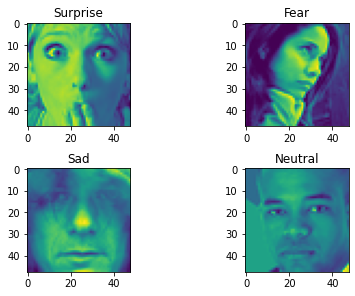

In [9]:
#randomly select 4 images
idx = np.random.choice(len(images),4,False)
plot_images([images[i] for i in idx] ,[labels[i] for i in idx])

In [0]:
num_clusters = 100
num_classes = 7
img_width = 48
img_height = 48

In [0]:
def extractSIFTDescriptors(image):
  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(image,None)
  return (kp,des)

def extractFeatures(images):
  #Stores all the descriptors found
  SIFTdesc = [] 
  #Each element corresponds to the descriptors found in an image
  img_desc = []
  for image in images:
    kp,des = extractSIFTDescriptors(image)
    if des is not None:
      SIFTdesc.extend(des)
      img_desc.append(des)
    else:
      img_desc.append([])
  return (SIFTdesc,img_desc)  

def constructHistogram(kmeans,image_descs,num_words):
  histograms = []
  for image_desc in image_descs:
      visual_words = []
      if len(image_desc):
        visual_words = kmeans.predict(image_desc)
      histograms.append(np.bincount(visual_words ,minlength=num_words))
  return np.array(histograms)

def constructVLAD(kmeans,image_descs,num_words):
  histograms = []
  code_book = kmeans.cluster_centers_
  for image_desc in image_descs:
      vlad = np.zeros((1,128))
      for key_point in image_desc:
        cluster_index = kmeans.predict(key_point.reshape(1,-1))
        vlad += code_book[cluster_index] - key_point
      histograms.extend(vlad)
  return np.array(preprocessing.normalize(histograms, norm='l2'))

In [12]:
%time SIFTdesc,image_desc = extractFeatures(images)

CPU times: user 2min 21s, sys: 10 s, total: 2min 31s
Wall time: 1min 16s


In [13]:
%time kmeans =   MiniBatchKMeans(init ='k-means++', n_clusters = num_clusters, batch_size = 64, verbose = 0).fit(SIFTdesc) 

CPU times: user 1min 25s, sys: 57.6 s, total: 2min 23s
Wall time: 1min 12s


In [14]:
%time X = constructVLAD(kmeans,image_desc,num_clusters)

CPU times: user 13min 18s, sys: 9min 31s, total: 22min 50s
Wall time: 11min 35s


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,labels,stratify=labels, test_size=0.2, random_state=42)

In [21]:
print("Train Set : " ,len(y_train),"images")
print("Test Set : " ,len(y_test),"images")

Train Set :  28709 images
Test Set :  7178 images


In [0]:
algo = KNeighborsClassifier(n_neighbors = 1)

In [34]:
%time algo.fit(X_train, y_train)

CPU times: user 506 ms, sys: 2.88 ms, total: 509 ms
Wall time: 512 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Evaluate the model

In [35]:
algo.score(X_test,y_test)

0.35525215937587074

##Plot the confusion matrix

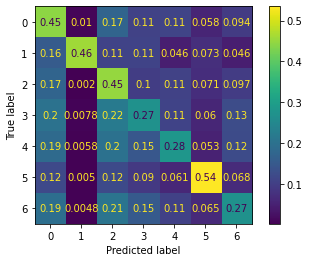

In [36]:
plot_confusion_matrix(algo,X_test,y_test,normalize='true')